In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import traceback
import numpy as np
import scipy.stats as ss
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

In [2]:
!{"ros2 run local_planning_performance_modelling compute_metrics -s"}

finished computing metrics 
finished writing results 


In [3]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.marker'] = 'o'

fg_color = 'white'
plt.rcParams['grid.color'] = 'gray'
plt.rcParams['text.color'] = fg_color
plt.rcParams['ytick.color'] = fg_color
plt.rcParams['xtick.color'] = fg_color
plt.rcParams['axes.labelcolor'] = fg_color
plt.rcParams['axes.edgecolor'] = fg_color

bg_color = "#323a48"
plt.rcParams['figure.facecolor'] = bg_color
plt.rcParams['axes.facecolor'] = bg_color
plt.rcParams['legend.facecolor'] = bg_color

In [4]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into alpha_1..4
results_info['run_parameter_names'] += ['alpha_1', 'alpha_2', 'alpha_3', 'alpha_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'alpha_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]
odometry_metrics = [c for c in metrics if 'odometry_error_alpha_' in c]
odometry_mean_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_mean' in c]
odometry_std_metrics = [c for c in metrics if 'odometry_error_alpha_' in c and '_std' in c]
odometry_parameters = [f'alpha_{i}' for i in range(1, 5)]
localization_update_metrics = [c for c in metrics if 'localization_update_' in c]
localization_update_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_mean' in c]
localization_update_translation_mean_metrics = [c for c in metrics if 'localization_update_' in c and '_translation_' in c and '_mean' in c]
navigation_metrics = [c for c in metrics if c in ['trajectory_length', 'execution_time', 'success_rate']]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

printmd("## Number of Runs")
printmd(f"    {len(df.run_id.unique())}")

printmd("## Run Parameters")
for name in run_parameters:
    values = list(df[name].unique())
    printmd(f"    {name:<70}", sorted(values))

printmd("## Metrics")
for name in metrics_and_versions:
    if name in metrics_versions:
        if len(df[name].unique()) == 1:
            printmd(f"    {name:<70} {sorted(df[name].unique())}")
        else:
            printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
    else:
        printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g}]")

## Number of Runs

    2304

## Run Parameters

    amcl_alpha_factor                                                      [0.0, 0.5, 0.75, 1.0, 1.5, 2.0]

    environment_name                                                       ['7A-2', 'airlab', 'fr079', 'intel', 'mexico', 'office_b']

    global_planner_node                                                    ['navfn', 'smac']

    local_planner_node                                                     ['dwb', 'rpp', 'teb']

    localization_node                                                      ['amcl']

    robot_model                                                            ['hunter', 'turtle']

    run_index                                                              [0, 1]

    max_steering_angle_deg                                                 [20.0, 40.0, 90.0]

    alpha_1                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_2                                                                [0.0]

    alpha_3                                                                [0.0, 0.02, 0.05, 0.1]

    alpha_4                                                                [0.0]

## Metrics

    controller_cpu_time                                                    min:       0.53             avg:        114             max:       1031]

    planner_cpu_time                                                       min:       0.32             avg:      28.93             max:      317.3]

    system_cpu_time                                                        min:       3.27             avg:      155.5             max:       1303]

    controller_max_memory                                                  min:      17.45             avg:      62.06             max:      78.79]

    planner_max_memory                                                     min:      17.39             avg:       1084             max:  3.109e+04]

    system_max_memory                                                      min:      114.3             avg:       1270             max:  3.126e+04]

    cpu_time_and_max_memory_version                                        [1]

    trajectory_length                                                      min:          0             avg:      19.88             max:      133.9]

    trajectory_length_version                                              [1]

    execution_time                                                         min:        0.2             avg:       88.7             max:      648.1]

    execution_time_version                                                 [1]

    success_rate                                                           min:          0             avg:     0.6098             max:          1]

    success_rate_version                                                   [1]

    odometry_error_alpha_1_mean                                            min:   1.43e-17             avg:    0.06093             max:      4.194]

    odometry_error_alpha_1_std                                             min:          0             avg:    0.09053             max:       13.9]

    odometry_error_alpha_2_mean                                            min:  4.546e-18             avg:    0.08289             max:      9.154]

    odometry_error_alpha_2_std                                             min:          0             avg:      0.167             max:      26.15]

    odometry_error_alpha_3_mean                                            min:  3.194e-18             avg:    0.05944             max:     0.8207]

    odometry_error_alpha_3_std                                             min:          0             avg:    0.01521             max:      1.417]

    odometry_error_alpha_4_mean                                            min:  4.648e-18             avg:     0.2364             max:      1.091]

    odometry_error_alpha_4_std                                             min:          0             avg:     0.2325             max:      1.809]

    odometry_error_version                                                 [1]

    localization_update_absolute_translation_error_mean                    min:   0.001657             avg:     0.1225             max:      3.385]

    localization_update_absolute_translation_error_std                     min:          0             avg:    0.06447             max:      2.915]

    localization_update_absolute_rotation_error_mean                       min:  0.0003956             avg:    0.02847             max:      1.145]

    localization_update_absolute_rotation_error_std                        min:          0             avg:     0.0419             max:      1.299]

    localization_update_relative_translation_error_mean                    min:   0.001501             avg:    0.01308             max:     0.4536]

    localization_update_relative_translation_error_std                     min:          0             avg:     0.0148             max:      0.649]

    localization_update_relative_rotation_error_mean                       min:  0.0002547             avg:    0.01113             max:     0.3784]

    localization_update_relative_rotation_error_std                        min:          0             avg:    0.03685             max:     0.6973]

    localization_update_normalized_relative_translation_error_mean         min:    0.00547             avg:    0.07224             max:      2.273]

    localization_update_normalized_relative_translation_error_std          min:          0             avg:     0.1071             max:         11]

    localization_update_normalized_relative_rotation_error_mean            min:   0.005072             avg:     0.1895             max:      12.29]

    localization_update_normalized_relative_rotation_error_std             min:          0             avg:      0.911             max:      43.93]

    localization_update_error_version                                      [1]

    localization_update_rate_mean                                          min:     0.3642             avg:       1.15             max:       37.4]

    localization_update_rate_std                                           min:          0             avg:      0.633             max:      14.34]

    localization_update_rate_version                                       [1]

In [5]:
df.groupby(['robot_model', 'local_planner_node', 'max_steering_angle_deg'])[navigation_metrics].agg(['mean', 'count'])

trajectory_length       execution_time       success_rate      
                                                                   mean count           mean count         mean count
robot_model local_planner_node max_steering_angle_deg                                                                
hunter      teb                20.000                            16.870   380         88.829   380        0.398   384
                               40.000                            14.188   382         73.967   382        0.393   384
turtle      dwb                90.000                            25.457   192        104.599   192        0.990   192
            rpp                90.000                            29.808   191         82.047   191        0.661   192
            teb                20.000                            24.387   383        117.641   383        0.698   384
                               40.000                            23.268   378        103.312   378        0.805   384
                               90.000                            12.862   379         54.884   379        0.539   384

Mean: 19.878162363236658


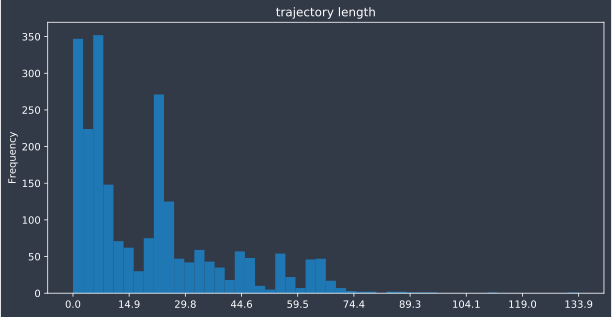

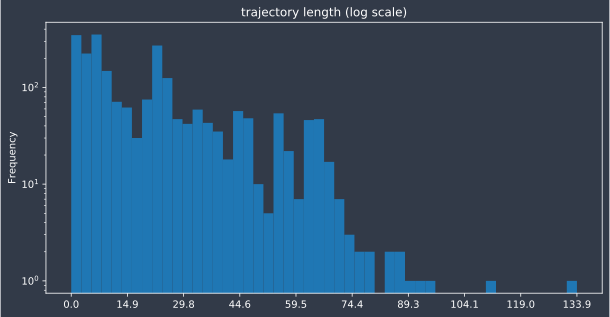

In [6]:
p = df.trajectory_length
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

Mean: 88.69770415754924


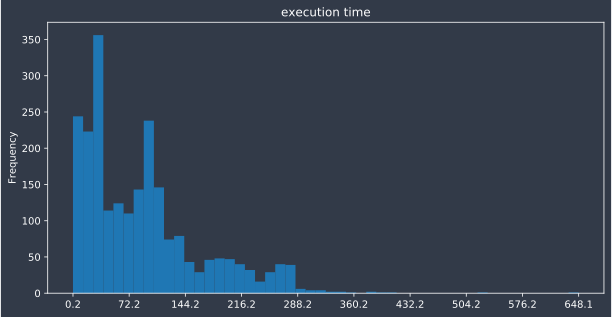

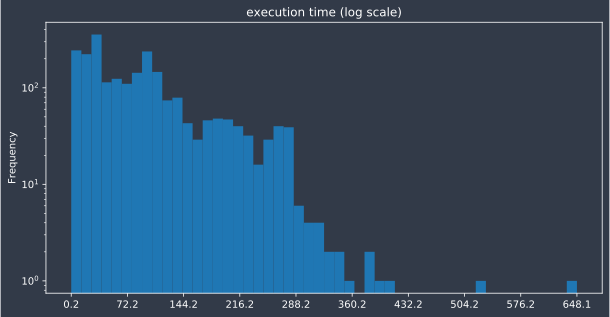

In [7]:
p = df.execution_time
num_bins=50
print("Mean:", p.mean())
p.plot.hist(bins=num_bins, figsize=[10, 5])
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' '))
plt.show()
b = p.plot.hist(bins=num_bins, figsize=[10, 5], log=True)
plt.xticks(np.linspace(p.min(), p.max(), num_bins/5))
plt.title(p.name.replace('_', ' ') + ' (log scale)')
plt.show()

mean  count
robot_model local_planner_node global_planner_node             
turtle      dwb                navfn               0.990    192
            teb                navfn               0.875    576
            rpp                navfn               0.661    192
hunter      teb                navfn               0.612    384
turtle      teb                smac                0.486    576
hunter      teb                smac                0.180    384

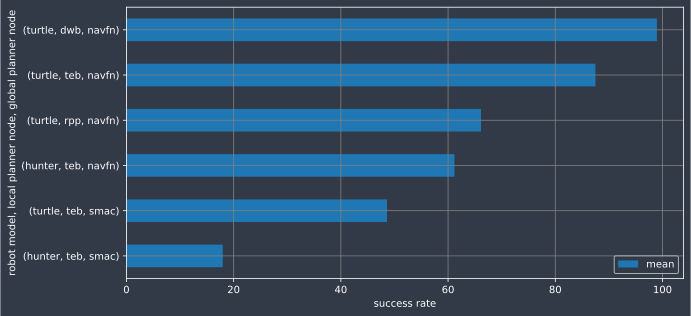

In [8]:
success_rate_df = df.groupby([df.robot_model, df.local_planner_node, df.global_planner_node])['success_rate'].agg(['mean', 'count']).sort_values(by=('mean'), ascending=False)
ax = (success_rate_df.sort_values(by=('mean'), ascending=True)*100).plot.barh(y=[('mean')], stacked=True, figsize=[10, 5], grid=True)
ax.set_xlabel("success rate")
ax.set_ylabel(ax.get_ylabel().replace('_', ' ').replace(',', ', '))
success_rate_df

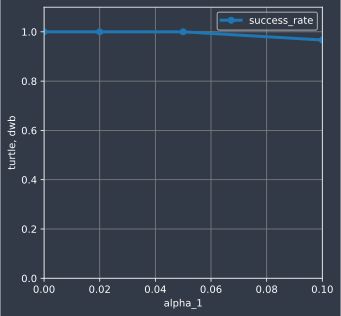

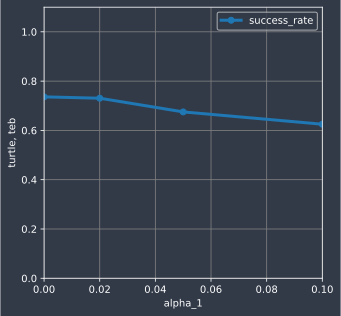

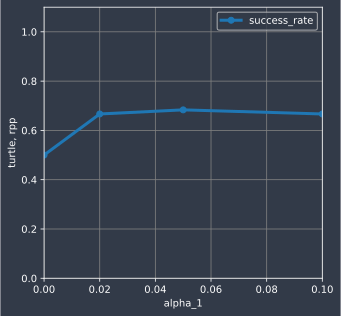

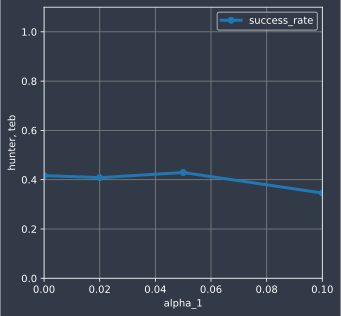

In [9]:
for robot_model in df.robot_model.unique():
    for local_planner_node in df.local_planner_node.unique():
        if len(df[(df.local_planner_node == local_planner_node) & (df.robot_model == robot_model)]):
            df[(df.local_planner_node == local_planner_node) & (df.robot_model == robot_model)].groupby('alpha_1').success_rate.mean().plot(x='alpha_1', grid=True, figsize=[5, 5])
            plt.legend()
            plt.ylabel(f"{robot_model}, {local_planner_node}")
            plt.ylim([0, 1.1])
            plt.show()

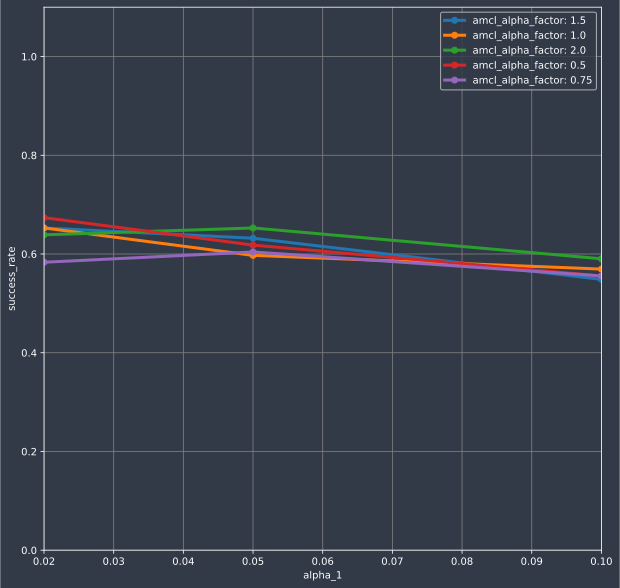

In [10]:
for amcl_alpha_factor in df[df.amcl_alpha_factor > 0].amcl_alpha_factor.unique():
    df[df.amcl_alpha_factor == amcl_alpha_factor].groupby('alpha_1').success_rate.mean().plot(x='alpha_1', label=f"amcl_alpha_factor: {amcl_alpha_factor}", grid=True)
    plt.legend()
#     plt.ylabel(f"amcl_alpha_factor: {amcl_alpha_factor}")
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

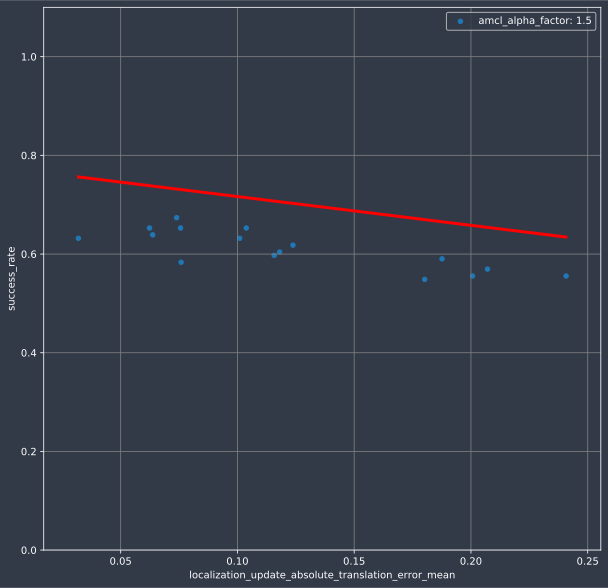

In [21]:
df.groupby(['alpha_1', 'amcl_alpha_factor']).mean().plot.scatter(x='localization_update_absolute_translation_error_mean', y='success_rate', label=f"amcl_alpha_factor: {amcl_alpha_factor}", grid=True)

df_lr = df[df.localization_update_absolute_translation_error_mean.notna() & df.success_rate.notna()].groupby(['alpha_1', 'amcl_alpha_factor']).mean()
X = df_lr.localization_update_absolute_translation_error_mean.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_lr.success_rate.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, '-', color='red')

plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()

No handles with labels found to put in legend.


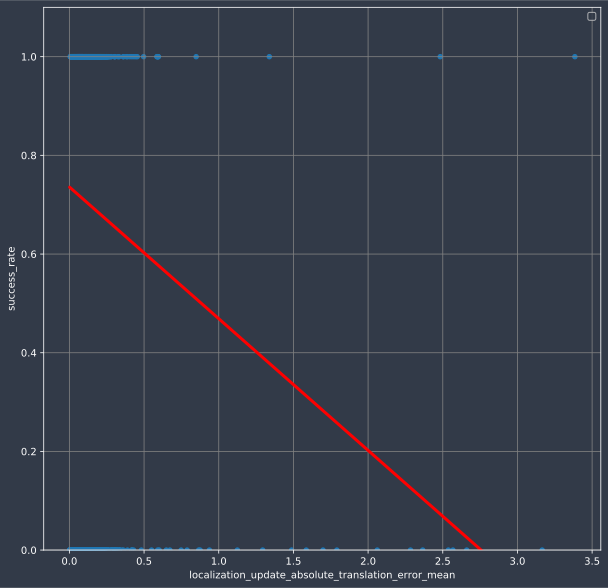

In [20]:
df.plot.scatter(x='localization_update_absolute_translation_error_mean', y='success_rate', grid=True)

df_lr = df[df.localization_update_absolute_translation_error_mean.notna() & df.success_rate.notna()]
X = df_lr.localization_update_absolute_translation_error_mean.values.reshape(-1, 1)  # values converts it into a numpy array
Y = df_lr.success_rate.values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.plot(X, Y_pred, '-', color='red')

plt.legend()
plt.ylabel('success_rate')
plt.ylim([0, 1.1])
plt.show()